# Store sales time series

## Imports and load data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
holiday_events = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])
oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
sample_submission = pd.read_csv('../input/store-sales-time-series-forecasting/sample_submission.csv')
stores = pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv')
test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv', parse_dates=['date'])
train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
transactions = pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv', parse_dates=['date'])

In [3]:
figsize=(20,12)

## Functions

## Data analysis

### Oil

In [4]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [5]:
oil.isna().value_counts()

date   dcoilwtico
False  False         1175
       True            43
dtype: int64

In [6]:
#fill na using backward fill technique
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='bfill')
oil.isna().value_counts()

date   dcoilwtico
False  False         1218
dtype: int64

In [7]:
oil.dtypes

date          datetime64[ns]
dcoilwtico           float64
dtype: object

In [8]:
moving_average_mean = oil.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)
moving_average_mean = moving_average_mean.rename(columns={'dcoilwtico':'dcoilwtico_mean_trend'})

moving_average_median = oil.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).median()   
moving_average_median = moving_average_median.rename(columns={'dcoilwtico':'dcoilwtico_median_trend'})

In [9]:
oil = oil.join([moving_average_mean, moving_average_median])#.set_index('date')

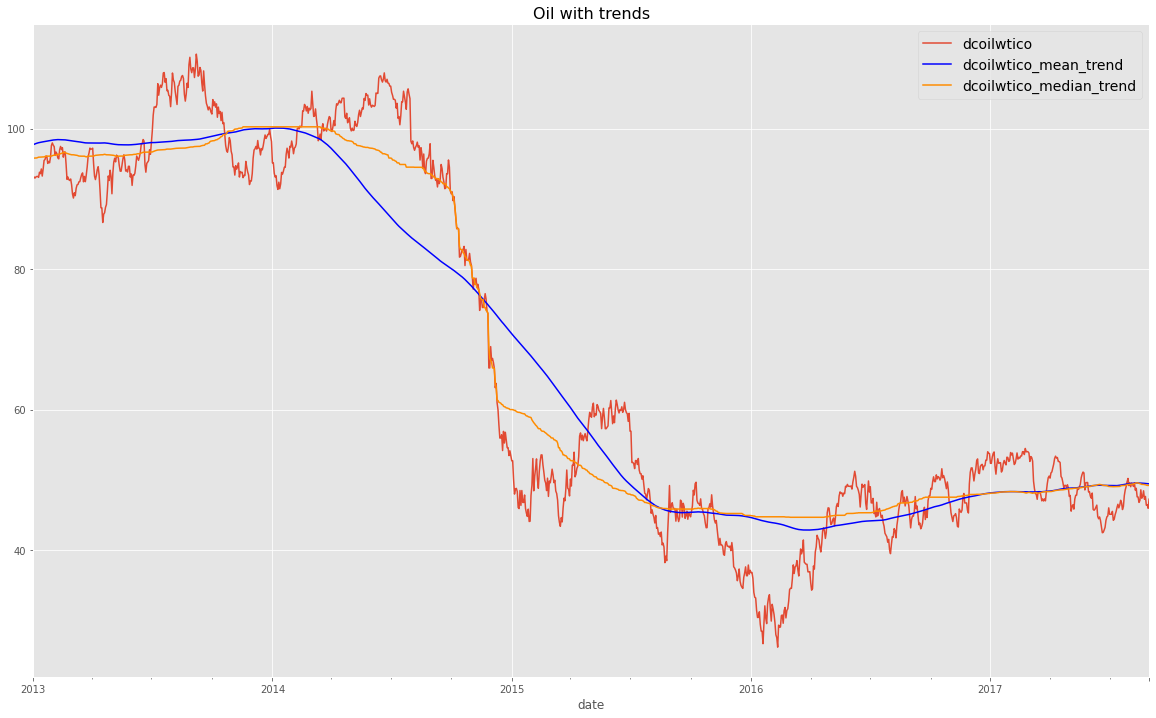

In [10]:
mpl.style.use('ggplot')
# mpl.rcParams['lines.linewidth'] = 1


ax = plt.gca()

oil.plot(x='date', y='dcoilwtico', figsize=figsize, ax=ax)
oil.plot(x='date', y='dcoilwtico_mean_trend', color='blue',ax=ax)
oil.plot(x='date', y='dcoilwtico_median_trend', color='darkorange', ax=ax)

plt.title('Oil with trends', fontsize=16)
plt.legend(fontsize=14)

plt.show()

### Transactions

In [11]:
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [12]:
transactions.isna().value_counts()

date   store_nbr  transactions
False  False      False           83488
dtype: int64

In [13]:
transactions_shop_sum = transactions.groupby(['store_nbr']).sum()
transactions_shop_sum.head()

,transactions
store_nbr,
1,2553963
2,3219901
3,5366350
4,2519007
5,2347877


In [14]:
tss_size = transactions_shop_sum.size

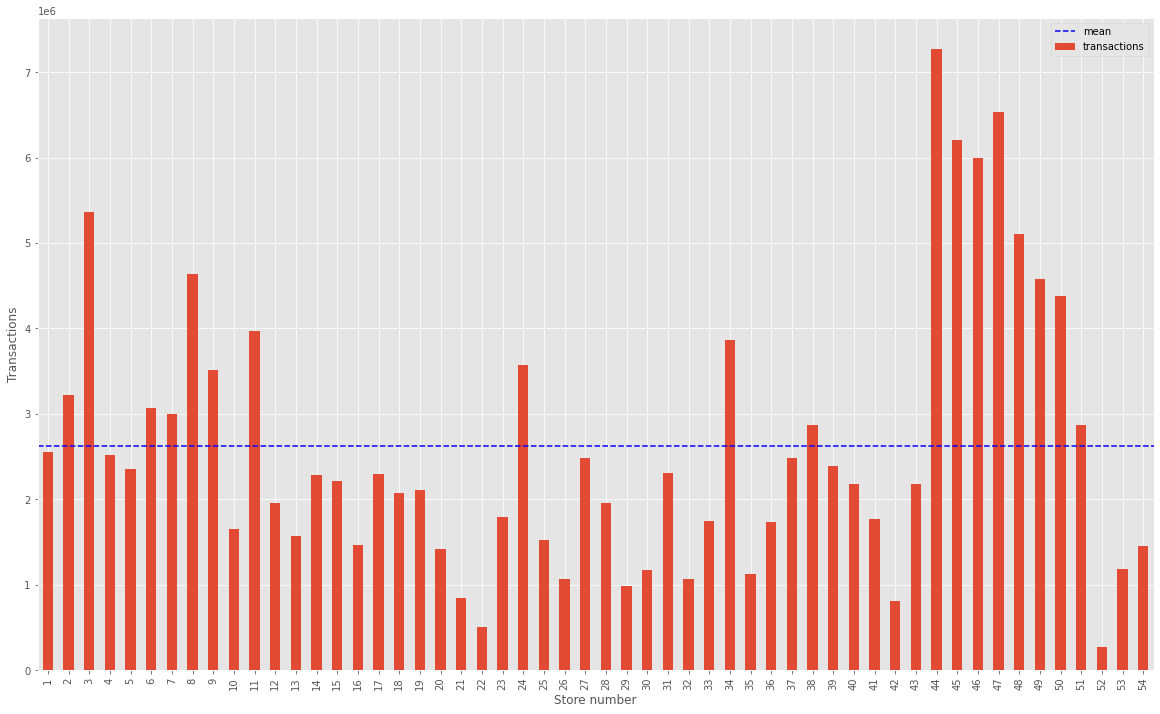

In [15]:
transactions_shop_mean = transactions_shop_sum['transactions'].mean()

ax = plt.gca()

transactions_shop_sum.plot.bar(y='transactions', figsize=figsize, ax=ax)

plt.axhline(y=transactions_shop_mean, linestyle='--', color='b', label='mean')
plt.xlabel('Store number')
plt.ylabel('Transactions')
plt.legend(fontsize=10)

plt.show()

In [16]:
transactions_daily_sum = transactions.groupby('date').sum()
transactions_daily_sum

,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1210,93215
2013-01-03,1210,78504
2013-01-04,1210,78494
2013-01-05,1210,93573
...,...,...
2017-08-11,1485,89551
2017-08-12,1485,89927
2017-08-13,1485,85993


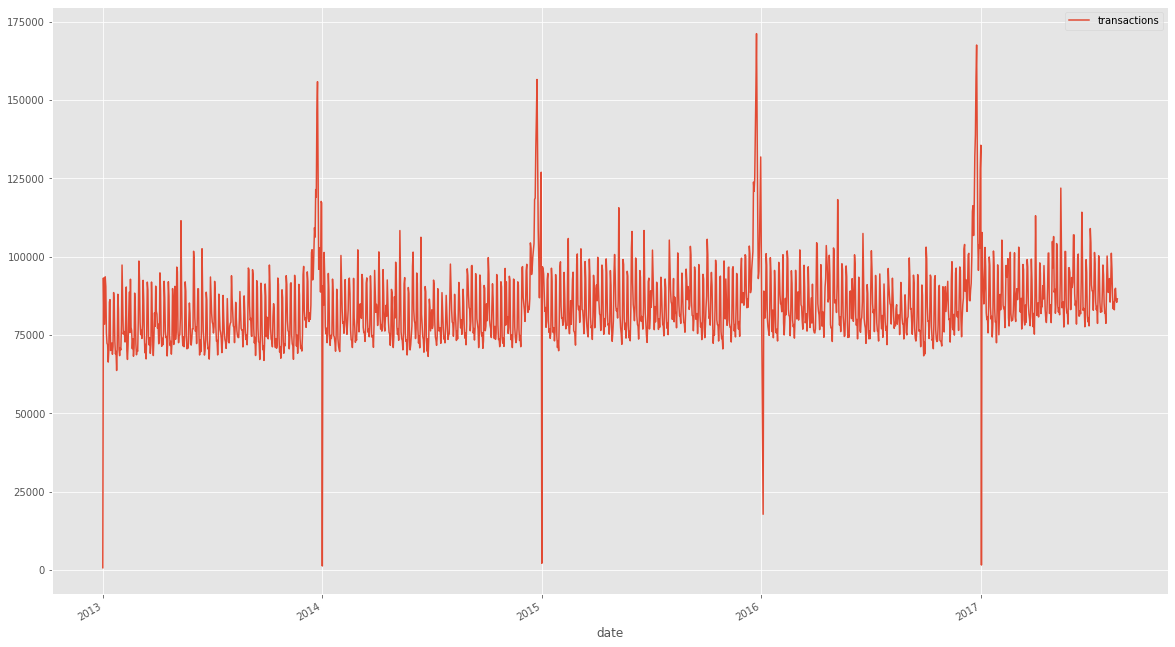

In [17]:
transactions_daily_sum.plot(y='transactions', figsize=figsize);

### Holidays

In [18]:
holiday_events

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [19]:
holiday_events.isna().value_counts()

date   type   locale  locale_name  description  transferred
False  False  False   False        False        False          350
dtype: int64

### Stores

In [20]:
stores.head(10)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [21]:
stores.isna().value_counts()

store_nbr  city   state  type   cluster
False      False  False  False  False      54
dtype: int64

In [22]:
stores.city.value_counts()

Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Manta             2
Latacunga         2
Machala           2
Ambato            2
Quevedo           1
Esmeraldas        1
Loja              1
Libertad          1
Playas            1
Daule             1
Babahoyo          1
Salinas           1
Puyo              1
Guaranda          1
Ibarra            1
Riobamba          1
Cayambe           1
El Carmen         1
Name: city, dtype: int64

### Train data

In [23]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [24]:
# train.set_index('id', inplace=True)
train['date'] = train.date.dt.to_period("D")
train.set_index('date', inplace=True)
train.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [25]:
train.isna().value_counts()

id     store_nbr  family  sales  onpromotion
False  False      False   False  False          3000888
dtype: int64

In [26]:
train.dtypes

id               int64
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

In [27]:
train.family.value_counts()

AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
POULTRY                       90936
PLAYERS AND ELECTRONICS       90936
PET SUPPLIES                  90936
PERSONAL CARE                 90936
MEATS                         90936
MAGAZINES                     90936
LIQUOR,WINE,BEER              90936
LINGERIE                      90936
LAWN AND GARDEN               90936
LADIESWEAR                    90936
HOME CARE                     90936
HOME AND KITCHEN II           90936
BABY CARE                     90936
HOME AND KITCHEN I            90936
HARDWARE                      90936
GROCERY II                    90936
GROCERY I                     90936
FROZEN FOODS                  90936
EGGS                          90936
DELI                          90936
DAIRY                         90936
CLEANING                      90936
CELEBRATION                 

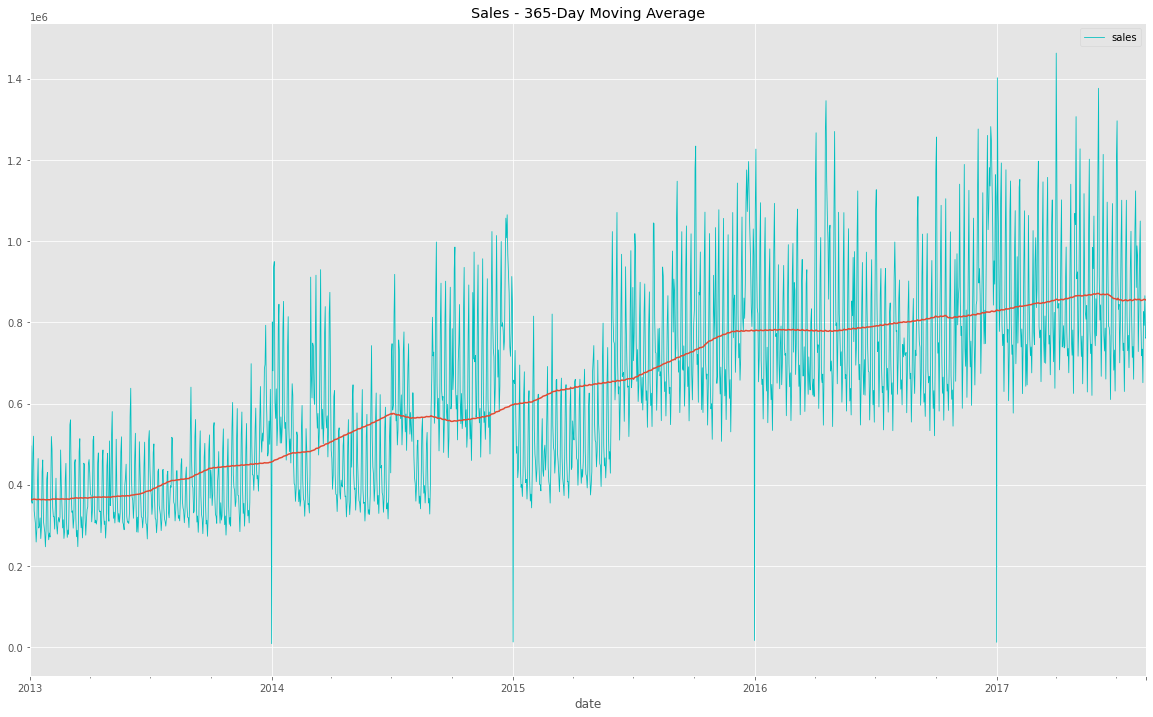

In [28]:
train_daily_sales = pd.DataFrame(train.groupby('date').sum()['sales'])
moving_average = train_daily_sales.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()     

ax = train_daily_sales.plot(y='sales', linewidth=0.8, color='c', figsize=figsize)
moving_average.plot(y='sales',
    ax=ax, title="Sales - 365-Day Moving Average", legend=False
);

In [29]:
# train_daily_sales = pd.DataFrame(train_daily_sales)
train_daily_sales

,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229
...,...
2017-08-11,826373.722022
2017-08-12,792630.535079
2017-08-13,865639.677471


In [30]:
train_daily_sales['dayofweek'] = train_daily_sales.index.dayofweek
# train_daily_sales['week'] = train_daily_sales.index.week
train_daily_sales['week'] = train_daily_sales.index.week

train_daily_sales['dayofyear'] = train_daily_sales.index.dayofyear
train_daily_sales['year'] = train_daily_sales.index.year

In [31]:
# train_daily_sales = train_daily_sales.astype({'week': 'int64'})
# train_daily_sales.dtypes

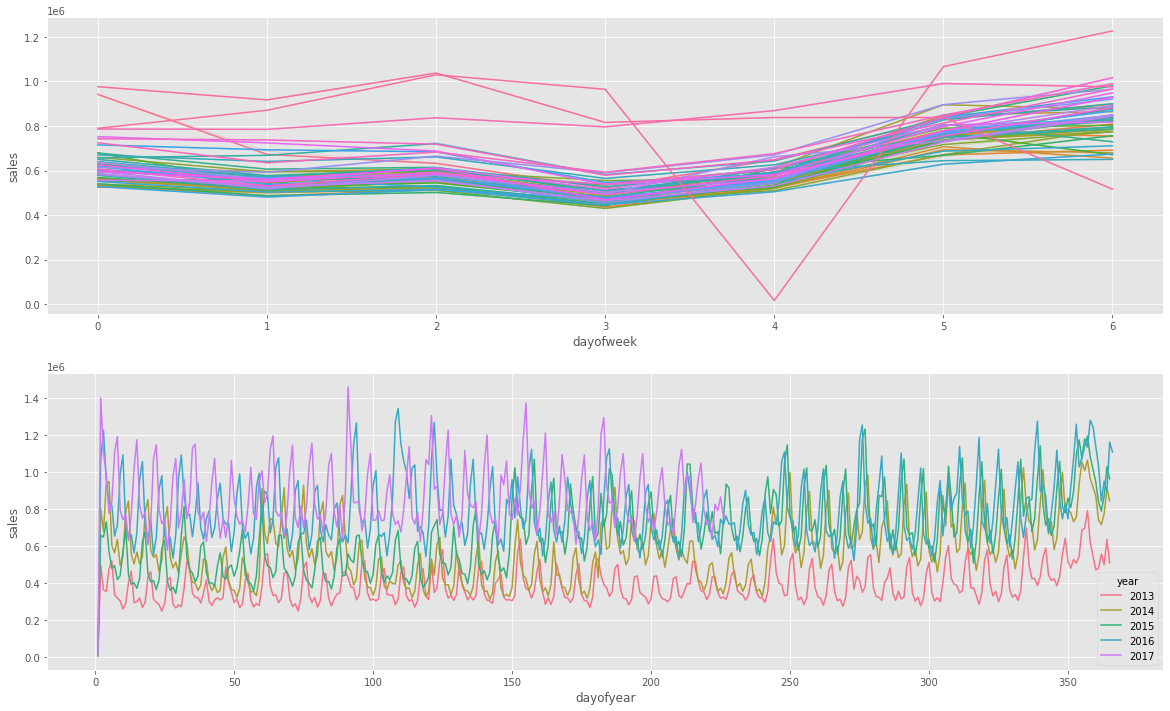

In [32]:
## TODO
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=figsize)
palette = sns.color_palette("husl", n_colors=train_daily_sales['week'].nunique(),)
ax0 = sns.lineplot(x='dayofweek', y='sales', hue='week', data=train_daily_sales, 
                  ci=False, ax=ax0, palette=palette, legend=False)

palette = sns.color_palette("husl", n_colors=train_daily_sales['year'].nunique(),)
ax1 = sns.lineplot(x='dayofyear', y='sales', hue='year', data=train_daily_sales, 
                  ci=False, ax=ax1, palette=palette, legend=True)

In [33]:
from scipy.signal import periodogram

def plot_periodogram(ds, ax=None):
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ds, 
                                       fs=fs, 
                                       detrend='linear', 
                                       window="boxcar", 
                                       scaling='spectrum',
                                      )

    fig, ax = plt.subplots(figsize=figsize)
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
        "Annual (1)",
        "Semiannual (2)",
        "Quarterly (4)",
        "Bimonthly (6)",
        "Monthly (12)",
        "Biweekly (26)",
        "Weekly (52)",
        "Semiweekly (104)",
    ],
        rotation=30,)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram");
    return ax

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """Entry point for launching an IPython kernel.


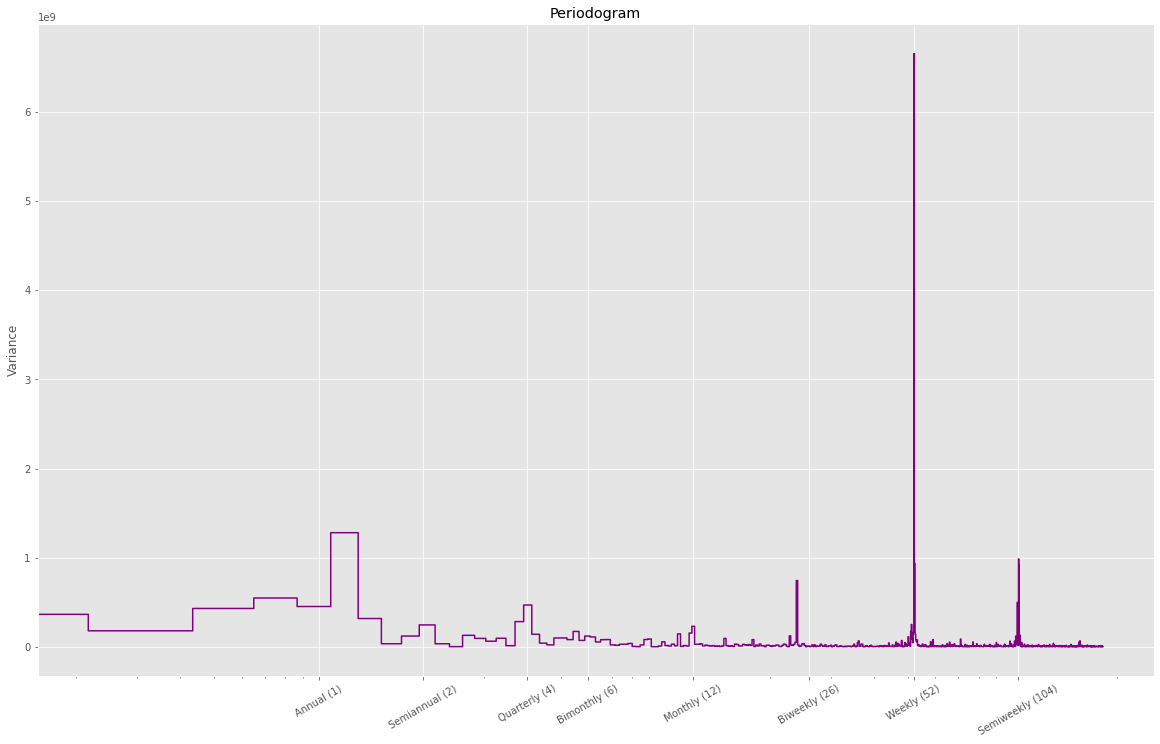

In [34]:
plot_periodogram(train_daily_sales.sales);

### Test data

In [35]:
test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


## Model

### Split

In [36]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=train_daily_sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=2,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend,trend_squared
date,,,
2013-01-01,1.0,1.0,1.0
2013-01-02,1.0,2.0,4.0
2013-01-03,1.0,3.0,9.0
2013-01-04,1.0,4.0,16.0
2013-01-05,1.0,5.0,25.0


In [37]:
from sklearn.linear_model import LinearRegression

y = train_daily_sales['sales']  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
trend = LinearRegression(fit_intercept=False)
trend.fit(X, y)

y_pred = pd.Series(trend.predict(X), index=X.index)

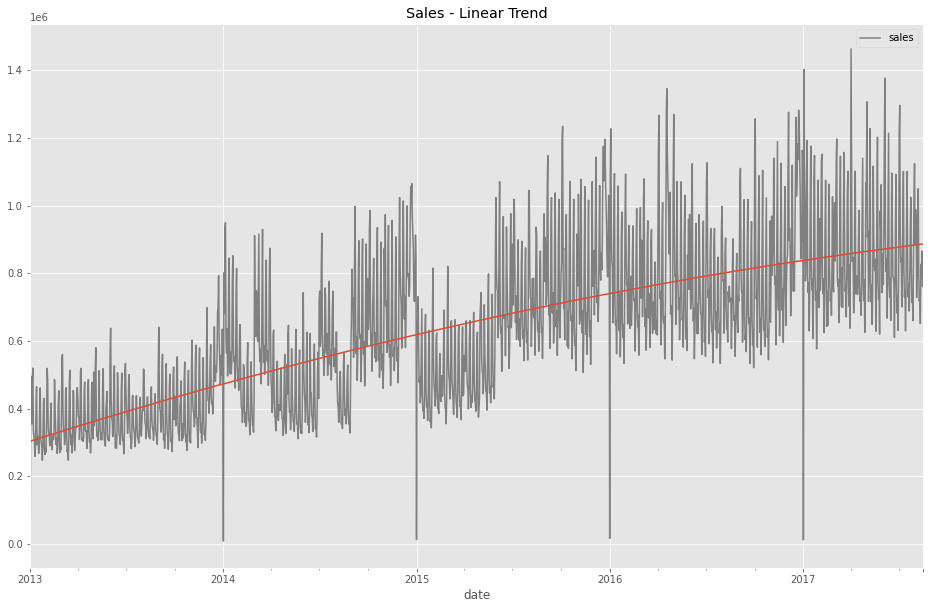

In [38]:
ax = train_daily_sales.plot(y='sales', color="0.5", figsize=figsize, title="Sales - Linear Trend")
_ = y_pred.plot(figsize=(16,10), ax=ax);

In [39]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=12)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=train_daily_sales.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=2,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

### Deseasonalised

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  


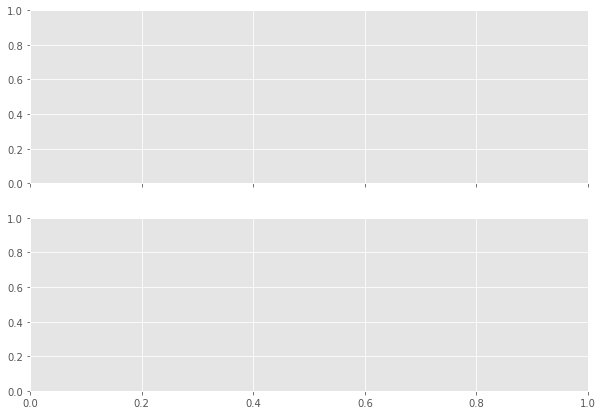

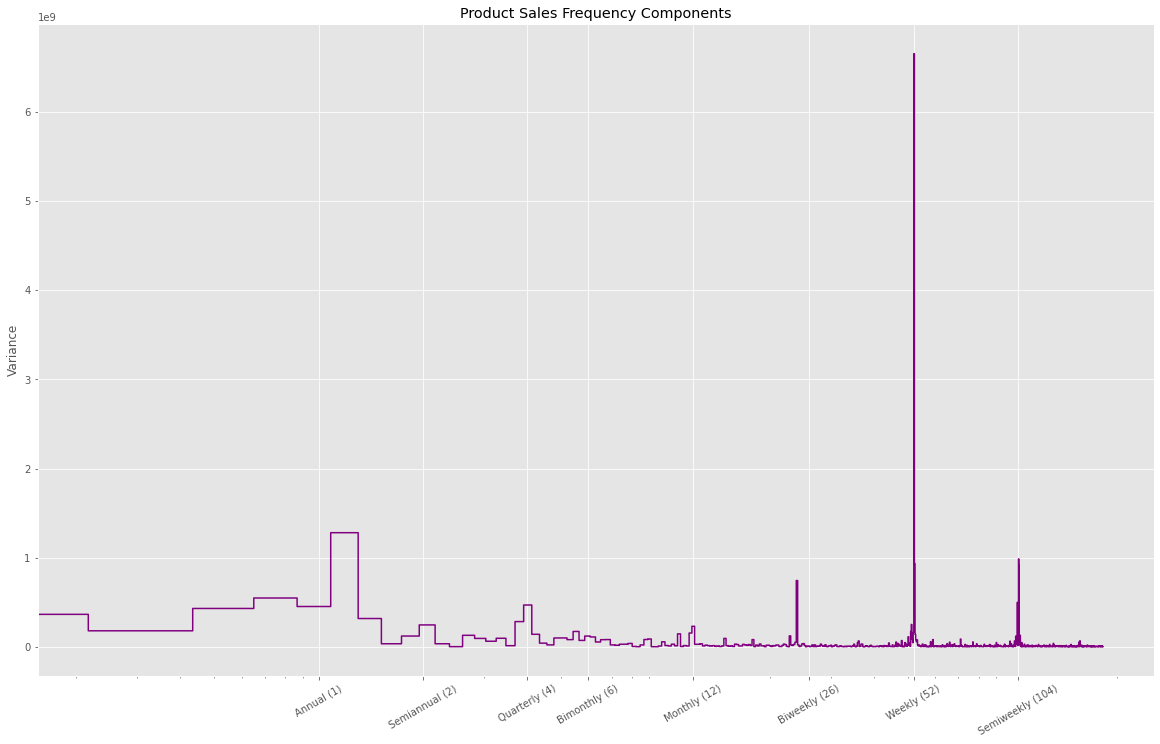

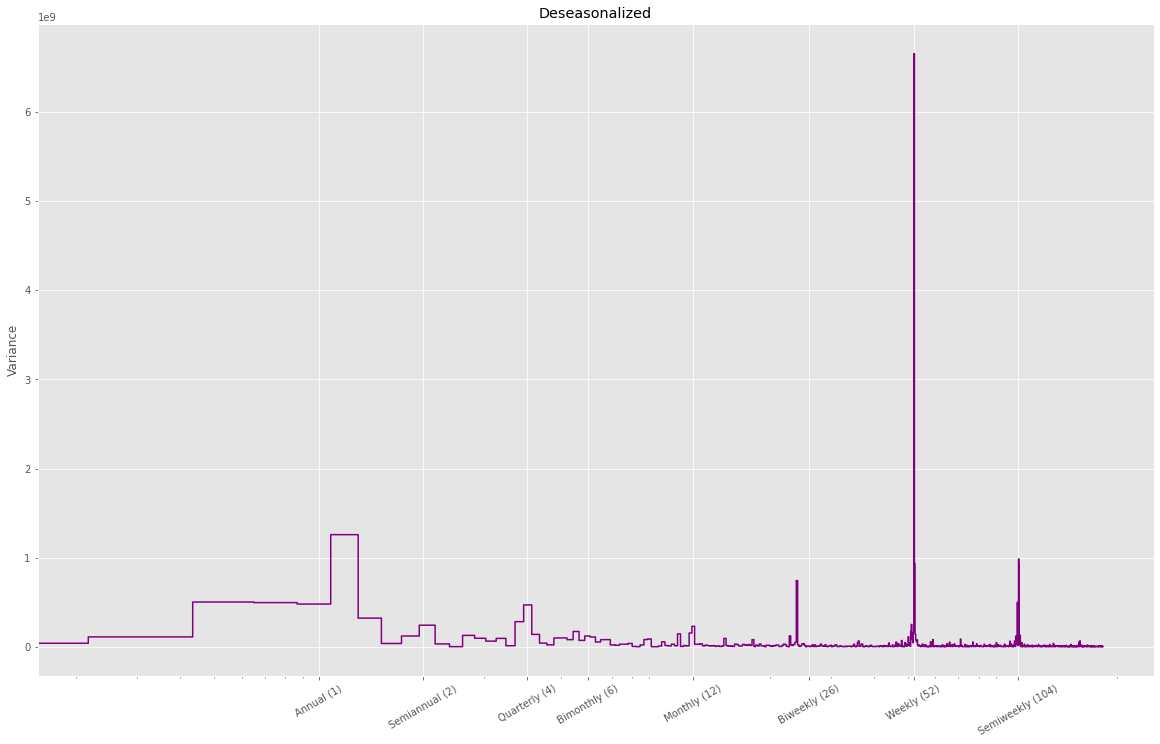

In [40]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

In [41]:
sample_submission

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
...,...,...
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0


In [42]:
test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9
